# Huawei - Senior Big Data Engineer Task

AYTEKİN YILDIZHAN

**Task – 2 Recommender Design:**

Dataset : Provided database with name ‘movielens-small’

* 1- Provide an implicit feature by using any of the data from the given database
* 2- Train two individual recommender models, one by using rating (from ratings table) and the other one by using your designed implicit feedback
* 3- Present comparison between two models, by using essential metrics
____

# FIRST QUESTION
____________

In [ ]:
# HERE IS OUR LIBRARIES THAT WE USE IN SWCOND PART.

In [8]:
import sqlite3
import pandas as pd
import sqlalchemy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
from mxnet import gluon, np
from d2l import mxnet as d2l

from __future__ import print_function
#skbuild
# mxnet-cu101==1.7.0
# d2l==0.17.2
import argparse
import codecs
import logging
import time

import tqdm

from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.datasets.movielens import get_movielens
from implicit.lmf import LogisticMatrixFactorization
from implicit.nearest_neighbours import (
    BM25Recommender,
    CosineRecommender,
    TFIDFRecommender,
    bm25_weight,
)

In [2]:
# CREATING FILE PATH OUR DATABASE 'movielens-small'
dbfile = '.\movielens-small.db'

# CREATING A SQL CONNECTION TO OUR SQLITE DATABASE
conn = sqlite3.connect(dbfile)

# CREATING CURSOR
cur = conn.cursor()

# WE READ ALL TABLE NAMES
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

# HERE IS OUR TABLE NAME LIST
print(table_list)

# CLOSING SQL QUERY. WE USE IN THE LAST QUERY.
#conn.close()

[('movies',), ('ratings',), ('links',), ('tags',)]


In [3]:
# OUR TABLE NAMES ARE movies, ratings, links and tags

# SHOWING ALL COLUMN of MOVIES CONTENTS

cur.execute("SELECT * from movies")
records = cur.fetchall()
print(records)

[(1, 'Toy Story', 1995, 'Adventure|Animation|Children|Comedy|Fantasy'), (2, 'Jumanji', 1995, 'Adventure|Children|Fantasy'), (3, 'Grumpier Old Men', 1995, 'Comedy|Romance'), (4, 'Waiting to Exhale', 1995, 'Comedy|Drama|Romance'), (5, 'Father of the Bride Part II', 1995, 'Comedy'), (6, 'Heat', 1995, 'Action|Crime|Thriller'), (7, 'Sabrina', 1995, 'Comedy|Romance'), (8, 'Tom and Huck', 1995, 'Adventure|Children'), (9, 'Sudden Death', 1995, 'Action'), (10, 'GoldenEye', 1995, 'Action|Adventure|Thriller'), (11, 'American President, The', 1995, 'Comedy|Drama|Romance'), (12, 'Dracula: Dead and Loving It', 1995, 'Comedy|Horror'), (13, 'Balto', 1995, 'Adventure|Animation|Children'), (14, 'Nixon', 1995, 'Drama'), (15, 'Cutthroat Island', 1995, 'Action|Adventure|Romance'), (16, 'Casino', 1995, 'Crime|Drama'), (17, 'Sense and Sensibility', 1995, 'Drama|Romance'), (18, 'Four Rooms', 1995, 'Comedy'), (19, 'Ace Ventura: When Nature Calls', 1995, 'Comedy'), (20, 'Money Train', 1995, 'Action|Comedy|Crime

In [4]:
# We assign the movies to Dataframe 'df_movies' and also save a .cvs file.

df_movies = pd.read_sql_query('SELECT * FROM movies', conn)
#df_movies.to_csv (r'movies.csv', index = False, header=True)

#df_movies

In [5]:
df_ratings = pd.read_sql_query('SELECT * FROM ratings', conn)
#df_ratings.to_csv (r'ratings.csv', index = False, header=True)

#df_ratings

In [6]:
df_links = pd.read_sql_query('SELECT * FROM links', conn)
#df_links.to_csv (r'links.csv', index = False, header=True)

#df_links

In [7]:
df_tags = pd.read_sql_query('SELECT * FROM tags', conn)
#df_tags.to_csv(r'tags.csv', index = False, header=True)

#df_tags

In [11]:
# We read the df_ratings data which is rating table from dataset.

def read_data(): return df_ratings, num_users, num_items
# df_ratings, num_users, num_items = read_data()

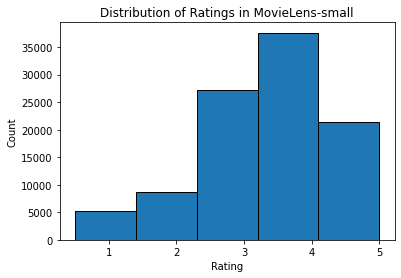

In [12]:
# Distribution of df_ratings

plt.hist(df_ratings['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens-small')
plt.show()

In [13]:
num_users = df_ratings.userId.unique().shape[0]
num_items = df_ratings.movieId.unique().shape[0]

In [14]:
sparsity = 1 - len(df_ratings) / (num_users * num_items) # our sparsity matrix

In [15]:
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(df_ratings.head(5))

number of users: 706, number of items: 8552
matrix sparsity: 0.983434
   userId  movieId  rating  timestamp
0       1        6     2.0  980730861
1       1       22     3.0  980731380
2       1       32     2.0  980731926
3       1       50     5.0  980732037
4       1      110     4.0  980730408


In [16]:
# This function is show that Splitting the dataset in random mode or seq-aware mode.

def split_data(df_ratings, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    
    if split_mode == 'seq-aware':
        
        train_items, test_items, train_list = {}, {}, []
        
        for line in df_ratings.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(df_ratings))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = df_ratings[mask], df_ratings[neg_mask]
    return train_data, test_data

In [20]:
# This function reads the dataframe line by line and enumerates the index of users/items start from zero.

def load_data(df_ratings, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    
    for line in df_ratings.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [24]:
def split_and_load(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    
    df_ratings, num_users, num_items = read_data()
    
    train_data, test_data = split_data(
        df_ratings, num_users, num_items, split_mode, test_ratio)
    
    train_u, train_i, train_r, _ = load_data(     #training
        train_data, num_users, num_items, feedback)
    
    test_u, test_i, test_r, _ = load_data(         #test
        test_data, num_users, num_items, feedback)
    
    train_set = gluon.data.ArrayDataset(
        np.array(train_u), np.array(train_i), np.array(train_r))
    
    test_set = gluon.data.ArrayDataset(
        np.array(test_u), np.array(test_i), np.array(test_r))
    
    train_iter = gluon.data.DataLoader(     #Dataloader for train
        train_set, shuffle=True, last_batch='rollover',
        batch_size=batch_size)
    
    test_iter = gluon.data.DataLoader(     #Dataloader for test
        test_set, batch_size=batch_size)
    
    return num_users, num_items, train_iter, test_iter

In [21]:
split_data(df_ratings, num_users, num_items, split_mode='random', test_ratio=0.1) #Splitting data

(        userId  movieId  rating  timestamp
 1            1       22     3.0  980731380
 2            1       32     2.0  980731926
 4            1      110     4.0  980730408
 6            1      198     3.0  980731282
 7            1      260     5.0  980730769
 ...        ...      ...     ...        ...
 100018     706     1023     4.0  841429779
 100019     706     1073     3.0  852915721
 100020     706     1150     3.0  847647519
 100021     706     1183     4.0  850465137
 100022     706     1356     4.0  852915765
 
 [89971 rows x 4 columns],
         userId  movieId  rating  timestamp
 0            1        6     2.0  980730861
 3            1       50     5.0  980732037
 5            1      164     3.0  980731766
 8            1      296     4.0  980731208
 35           1      913     3.0  980731647
 ...        ...      ...     ...        ...
 99990      706      364     3.0  832056660
 99997      706      457     4.0  831742016
 100008     706      585     4.0  831741763
 10

In [22]:
load_data(df_ratings, num_users, num_items, feedback='implicit') #we choose implicit feature

([0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [25]:
split_and_load(split_mode='seq-aware', feedback='implicit', test_ratio=0.1, batch_size=256)

(706,
 8552,
 <mxnet.gluon.data.dataloader.DataLoader at 0x2b4f32fb280>)

In [ ]:
# Our system select 706 and 8552 movieID